# Clean FERC Form 1

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Standard libraries
import logging
import sys
import os
import pathlib

# 3rd party libraries
import geopandas as gpd
import dask.dataframe as dd
from dask.distributed import Client
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import sqlalchemy as sa
import pickle

# Local libraries
import pudl

In [3]:
# Enable viewing of logging outputs
logger=logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]

In [4]:
# Display settings
sns.set()
%matplotlib inline
mpl.rcParams['figure.dpi'] = 75
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [5]:
# Establish connection to pudl database
pudl_settings = pudl.workspace.setup.get_defaults()
pudl_engine = sa.create_engine(pudl_settings['pudl_db'])
pudl_out = pudl.output.pudltabl.PudlTabl(
    pudl_engine=pudl_engine,
    freq='AS'
)

In [6]:
ferc1_years = pudl.constants.working_partitions['ferc1']['years']
ferc1_tables = ['fuel_ferc1','plants_steam_ferc1'] 
ferc1_raw_dfs = pudl.extract.ferc1.extract(
        ferc1_tables=ferc1_tables,
        ferc1_years=ferc1_years,
        pudl_settings=pudl_settings)

Converting extracted FERC Form 1 table fuel_ferc1 into a pandas DataFrame.
Converting extracted FERC Form 1 table plants_steam_ferc1 into a pandas DataFrame.


In [7]:
ferc1_transformed_dfs = pudl.transform.ferc1.transform(
         ferc1_raw_dfs, ferc1_tables=ferc1_tables)

Transforming raw FERC Form 1 dataframe for loading into fuel_ferc1
Transforming raw FERC Form 1 dataframe for loading into plants_steam_ferc1
Identifying distinct large FERC plants for ID assignment.
slimming fuel table
running fbp table
merging fractions with steam
filling nulls with zeros
traning classifier with default weights
generating groups of similar records
Successfully associated 22138 of 29270 (75.63%) FERC Form 1 plant records with multi-year plant entities.
Assigning IDs to multi-year FERC plant entities.
Identified 4695 orphaned FERC plant records. Adding orphans to list of plant entities.
Successfully Identified 2074 multi-year plant entities.
Found report_year=1994 3 times in plant_id_ferc1=93
Found report_year=1994 2 times in plant_id_ferc1=316
Found report_year=1995 2 times in plant_id_ferc1=316
Found report_year=1996 2 times in plant_id_ferc1=316
Found report_year=1997 2 times in plant_id_ferc1=316
Found report_year=1998 2 times in plant_id_ferc1=316
Found report_yea

In [10]:
with open('/Users/aesharpe/Desktop/ferc1_transformed.pickle', 'rb') as handle:
    ferc1_transformed_dfs = pickle.load(handle)

## Part 1.0: Fill in Missing Fuel

In [11]:
# Useful merge columns
ferc_merge_cols = ['report_year', 'utility_id_ferc1', 'plant_name_ferc1']
eia_merge_cols = ['report_date', 'plant_id_pudl', 'generator_id']

# Load the tables you'll need with some basic alterations
steam = ferc1_transformed_dfs['plants_steam_ferc1'].copy()
glue_dicts = pudl.glue.ferc1_eia.glue(ferc1=True) # For steam you'll have to mimic the glue process to get plant_id_pudl and add a column for primary fuel
steam = pd.merge(steam, glue_dicts['plants_ferc1'], on=['plant_name_ferc1', 'utility_id_ferc1'], how='left')
steam = pd.merge(steam, glue_dicts['utilities_ferc1'][['utility_id_ferc1', 'utility_name_ferc1']], on=['utility_id_ferc1'], how='left')
steam['primary_fuel'] = np.nan # Add column to document primary fuel

fuel = ferc1_transformed_dfs['fuel_ferc1']
fbp = pudl.transform.ferc1.fuel_by_plant_ferc1(fuel)
fbp_small = fbp[ferc_merge_cols + ['primary_fuel_by_mmbtu', 'primary_fuel_by_cost']]

plants = pudl_out.plants_eia860()
gens = pudl_out.gens_eia860()
net_gen = pudl_out.gen_eia923()

In [12]:
def test_for_duplicates(df, subset):
    test = df.copy()
    test['dup'] = test.duplicated(subset=subset)
    return f"number of duplicate index values for table: {len(test[test['dup']==True])}"
    #return test[test['dup']==True]['plant_name_ferc1'].unique()

print(test_for_duplicates(fuel, ferc_merge_cols))
print(test_for_duplicates(steam, ferc_merge_cols))

number of duplicate index values for table: 60679
number of duplicate index values for table: 2201


In [13]:
# FLAGS
flag1 = 'fuel in technology name'
flag2 = 'primary fuel by mmbtu'
flag3 = 'eia plant id has one fuel'
flag4 = 'primary fuel by cost'
flag5 = 'ferc pudl map all'# Make better one
flag6 = 'similar heat rate to other years'
flag7 = 'ferc plant id has one fuel'
flag8 = 'pudl plant id has one fuel'
flag9 = 'manually filled in'

In [14]:
def _add_new_fuel_and_flag(df, new_fuel_col, flag):
    """Add new fuels to the primary fuel column and flag where they came from."""
    df.loc[(df['primary_fuel'].isna()) & (df[f'{new_fuel_col}'].notna()), 'primary_fuel_flag'] = flag
    df['primary_fuel'] = df['primary_fuel'].fillna(df[f'{new_fuel_col}'])
    return df

def _check_flags(df):
    fuel = df[df['primary_fuel'].notna()]
    flag = df[df['primary_fuel_flag'].notna()]
    assert len(fuel) == len(flag), 'imputed fuels must be associated with a flag'
    return df

In [15]:
# Helpful function for viewing tests of large dataframes
def mini_df(df, plant_id, start, end, other_cols=False):
    basic_view = ['report_year', 'plant_name_ferc1', 'utility_id_ferc1', 'plant_type', 'primary_fuel', 'capacity_mw', 'total_type', 'plant_id_pudl', 'primary_fuel_flag', 'record_id', 'utility_name_ferc1']
    out_df = df[(df['plant_id_pudl']==plant_id) & (df['report_year'].isin(range(start, end)))]
    if other_cols:
        return out_df[basic_view + other_cols]
    else:
        return out_df[basic_view]

### **Step 0:** Delete bad rows and remove value rows with all NA values

In [16]:
# These plants are reported by Alabama power and represent the
# portions of plants owned by other utilities
bad_plant_ids = [11536, 8469, 381, 8468, 8467]

value_cols_no_cap = [
    'net_generation_mwh','avg_num_employees',
    'capex_land', 'capex_equipment', 'capex_structures', 'capex_total', 'asset_retirement_cost',
    'opex_operations', 'opex_fuel', 'opex_coolants', 'opex_steam', 'opex_steam_other', 'opex_transfer', 
    'opex_electric', 'opex_misc_power', 'opex_rents', 'opex_allowances', 'opex_engineering', 'opex_structures', 
    'opex_boiler', 'opex_plants', 'opex_misc_steam', 'opex_production_total'
]

steam0 = (
    steam.loc[~steam['plant_id_pudl'].isin(bad_plant_ids)].copy()
    .dropna(subset=value_cols_no_cap, how='all').copy()
)

In [17]:
print('rows with no fuel / total rows')
print(len(steam0[steam0['primary_fuel'].isna()]), '/', len(steam))

rows with no fuel / total rows
28514 / 29270


### **Step 1:** Get ones with obvious names

In [18]:
steam1 = steam0.copy()

steam1.loc[steam1['plant_name_ferc1'].str.contains('solar'), 'name_based'] = 'solar'
steam1.loc[steam1['plant_type'].str.contains('solar'), 'name_based'] = 'solar'
steam1.loc[steam1['plant_type'].str.contains('photovoltaic'), 'name_based'] = 'solar'
steam1.loc[steam1['plant_name_ferc1'].str.contains('wind'), 'name_based'] = 'wind'
steam1.loc[steam1['plant_type'].str.contains('wind'), 'name_based'] = 'wind'
steam1.loc[steam1['plant_type'].str.contains('nuclear'), 'name_based'] = 'nuclear'
steam1.loc[steam1['plant_name_ferc1'].str.contains('nuclear'), 'name_based'] = 'nuclear'
steam1.loc[steam1['plant_type'].str.contains('geothermal'), 'name_based'] = 'geothermal'

steam1 = (
    steam1.pipe(_add_new_fuel_and_flag, 'name_based', flag1)
    .pipe(_check_flags)
)

In [19]:
print('rows with no fuel / total rows')
print(len(steam1[steam1['primary_fuel'].isna()]), '/', len(steam0))

rows with no fuel / total rows
26492 / 28514


### **Step 2:** Primary fuel by mmbtu from fbp table

In [20]:
print(test_for_duplicates(fbp, ferc_merge_cols))
print(test_for_duplicates(steam1, ferc_merge_cols))

number of duplicate index values for table: 0
number of duplicate index values for table: 2018


In [21]:
# Merge steam and fbp table on steam table, clean primary_fuel_by_mmbtu col, add new fuel and flag
steam2 = (
    pd.merge(steam1, fbp_small, on=ferc_merge_cols, how='left')
    .assign(primary_fuel_by_mmbtu=lambda x: x.primary_fuel_by_mmbtu.replace({'':np.nan, 'unknown': np.nan}))
    .pipe(_add_new_fuel_and_flag, 'primary_fuel_by_mmbtu', flag2)
    .pipe(_check_flags)
)

In [22]:
test_for_duplicates(steam2, ferc_merge_cols)

'number of duplicate index values for table: 2018'

In [23]:
print('rows with no fuel / total rows')
print(len(steam2[steam2['primary_fuel'].isna()]), '/', len(steam0))

rows with no fuel / total rows
3416 / 28514


### **Step 3:** EIA plants with one reported fuel

In [63]:
# Only keep eia plants with one fuel
gens_by_plant = (
    gens.dropna(subset=['plant_id_pudl'])
    .copy()
    .assign(
        one_fuel=lambda x: (
            x.groupby(['report_date', 'plant_id_pudl'])['fuel_type_code_pudl']
            .transform(lambda x: len(x.dropna().unique()) == 1)),
        report_year=lambda x: x.report_date.dt.year
    )
)
gens_one_fuel = gens_by_plant[gens_by_plant['one_fuel']==True][['report_year', 'plant_id_pudl', 'fuel_type_code_pudl']].copy()

steam3 = (
    pd.merge(steam2, gens_one_fuel, on=['report_year', 'plant_id_pudl'], how='left')
    .pipe(_add_new_fuel_and_flag, 'fuel_type_code_pudl', flag3)
    .pipe(_check_flags)
)

In [25]:
# Combine fuel type from 860 with net generation from 923 to get fuel type and net generation
net_gen_fuel = (
    pd.merge(gens, net_gen[eia_merge_cols+['net_generation_mwh']], on=eia_merge_cols, how='outer')
    .assign(
        # Get plant net generation sums
        plant_net_gen=lambda x: (
            x.groupby(['report_date', 'plant_id_pudl']).net_generation_mwh.transform('sum')),
        # Calculate the portion of net generation that each row is responsible for
        gen_pct=lambda x: (
            x.net_generation_mwh / x.plant_net_gen * 100)
    )
)

# Calculate the sum portion of net generation attributable to each fuel type 
net_gen_fuel_sum = (
    net_gen_fuel.groupby(['report_date', 'plant_id_pudl', 'fuel_type_code_pudl'])['gen_pct']
    .sum()
    .reset_index()
    # Create flag to distinguish between rows that have more than one fuel (duplicates)
    .assign(dup=lambda x: x.duplicated(subset=['report_date', 'plant_id_pudl'], keep=False))
)

# Keep rows with only one fuel
one_fuel_eia = (
    net_gen_fuel_sum[~net_gen_fuel_sum['dup']].copy()
    .rename(columns={'fuel_type_code_pudl': 'primary_fuel_type_eia'})
    .assign(
        report_year=lambda x: x.report_date.dt.year,
        primary_fuel_type_eia=lambda x: x.primary_fuel_type_eia.replace({'':np.nan, 'unknown': np.nan, 'other': np.nan}))
    .drop(['report_date', 'gen_pct', 'dup'], axis=1)
)

# Combine steam table with EIA plant primary fuel type table, add flag to note fuel type location
steam3 = (
    pd.merge(steam2, one_fuel_eia, on=['report_year', 'plant_id_pudl'], how='left')
    .pipe(_add_new_fuel_and_flag, 'primary_fuel_type_eia', flag3)
    .pipe(_check_flags)
)

In [66]:
print('rows with no fuel / total rows')
print(len(steam3[steam3['primary_fuel'].isna()]), '/', len(steam0))

rows with no fuel / total rows
2175 / 28514


### **Step 4:** Primary fuel by cost from fbp table

In [67]:
steam4 = (
    steam3.assign(primary_fuel_by_cost=lambda x: x.primary_fuel_by_cost.replace({'':np.nan, 'unknown': np.nan, 'other': np.nan}))
    .pipe(_add_new_fuel_and_flag, 'primary_fuel_by_cost', flag4)
    .pipe(_check_flags)
)

In [68]:
print('rows with no fuel / total rows')
print(len(steam4[steam4['primary_fuel'].isna()]), '/', len(steam0))

rows with no fuel / total rows
1920 / 28514


### **Step 5:** raw FERC fuel

In [69]:
# Identify duplicate columns
fuel_dupes = (
    fuel.loc[fuel['fuel_type_code_pudl']!='unknown'].copy()
    .assign(dup=lambda x: x.duplicated(subset=ferc_merge_cols, keep=False))
)

# Only take fuels from plants without duplicate name/utility/year combos
fuel_ferc_no_dup = (
    fuel_dupes[~fuel_dupes['dup']][['report_year', 'utility_id_ferc1', 'plant_name_ferc1', 'fuel_type_code_pudl', 'fuel_avg_heat_raw', 'fuel_qty_burned']].copy() # keep fuel_avg_heat_raw and fuel_qty_burned in there for next round
    .rename(columns={'fuel_type_code_pudl':'fuel_type_code_pudl_ferc'})
)

steam5 = (
    pd.merge(steam4, fuel_ferc_no_dup, on=ferc_merge_cols, how='left')
    .pipe(_add_new_fuel_and_flag, 'fuel_type_code_pudl_ferc', flag5)
    .pipe(_check_flags)
)

In [70]:
print('rows with no fuel / total rows')
print(len(steam5[steam5['primary_fuel'].isna()]), '/', len(steam0))

rows with no fuel / total rows
1769 / 28514


### **Step 6:** FERC heat rate -- for now doesn't seem to do anything

In [71]:
def _create_dict(df):
    """Create a dict of fuel types and fuel_avg_heat ranges within 1% of median."""
    no_unk = df[(df['primary_fuel'].notna()) & (df['fuel_avg_heat_raw'].notna())]
    median_df = no_unk.groupby(['plant_name_ferc1', 'primary_fuel'])['fuel_avg_heat_raw'].median().reset_index()

    # Create dictionary of plant name, fuel, and heat rate
    fuel_dict = {}
    for i in median_df['plant_name_ferc1'].unique():
        fuel_dict[i] = dict(zip(
            median_df.loc[median_df['plant_name_ferc1'] == i]['primary_fuel'], 
            median_df.loc[median_df['plant_name_ferc1'] == i]['fuel_avg_heat_raw']
        ))
    # Turn the median values into ranges based on 1% buffer
    for k,v in fuel_dict.items():
        for kk,vv in v.items():
            v[kk] = range(int(vv-vv*0.01), int(vv+vv*0.01))
    return fuel_dict

def _test_for_overlap(fuel_dict):
    """See if there are any overlapping heat rate ranges for the same plant."""
    for k,v in fuel_dict.items():
        overlap_list = []
        rr = tuple(v.values())
        overlap = set(rr[0]).intersection(rr[1:])
        if overlap:
            overlap_list = overlap_list.append(k)
    return overlap_list

In [72]:
steam6 = (
    steam5.copy()
    .assign(ferc_fuel_by_heat_rate=np.nan)
)

fuel_dict = _create_dict(steam6)
overlap_list = _test_for_overlap(fuel_dict)
if overlap_list:
    print('The following plants have fuels with overlapping heat rates')
    print(overlap_list)
    
for plant_name, hr_dict in fuel_dict.items():
    # Get all heat rate values for a given plant name
    plant_df = steam6.loc[steam6['plant_name_ferc1']==plant_name].copy()
    # If the heat rate is within the range of one of the given fuels in the dictionary associated
    # with it's name, then give it that fuel label.
    plant_df['fuel_by_heat'] = (
        plant_df['fuel_avg_heat_raw']
        .apply(lambda x: next((fuel for fuel, heat_rate in hr_dict.items() if x in heat_rate), np.nan)))
    #print(plant_df['fuel_by_heat'])
    # Add these new fuels to the full table
    steam6['ferc_fuel_by_heat_rate'].update(plant_df['fuel_by_heat'])
    
steam6 = (
    steam6
    .pipe(_add_new_fuel_and_flag, 'ferc_fuel_by_heat_rate', flag6)
    .pipe(_check_flags)
)

In [73]:
print('rows with no fuel / total rows')
print(len(steam6[steam6['primary_fuel'].isna()]), '/', len(steam0))

rows with no fuel / total rows
1769 / 28514


### **Step 7:** Group by FERC plant id and fill in if all one fuel

In [74]:
plant_df = (
    steam6.groupby(['plant_id_ferc1'])['primary_fuel']
    .apply(lambda x: x.dropna().unique()[0] if len(x.dropna().unique()) ==1 else np.nan)
    .reset_index()
    .rename(columns={'primary_fuel':'ferc1_id_has_one_fuel'})
)

steam7 = (
    pd.merge(steam6, plant_df, on=['plant_id_ferc1'], how='left')
    .pipe(_add_new_fuel_and_flag, 'ferc1_id_has_one_fuel', flag7)
    .pipe(_check_flags)
)

In [75]:
print('rows with no fuel / total rows')
print(len(steam7[steam7['primary_fuel'].isna()]), '/', len(steam0))

rows with no fuel / total rows
1045 / 28514


In [76]:
test_for_duplicates(steam6, ferc_merge_cols)

'number of duplicate index values for table: 28950'

In [77]:
len(steam6)

55446

### **Step 8:** Group by PUDL plant id and fill in if all one fuel

In [78]:
plant_df = (
    steam7.groupby(['plant_id_pudl'])['primary_fuel']
    .apply(lambda x: x.dropna().unique()[0] if len(x.dropna().unique()) ==1 else np.nan)
    .reset_index()
    .rename(columns={'primary_fuel':'pudl_id_has_one_fuel'})
)

steam8 = (
    pd.merge(steam7, plant_df, on=['plant_id_pudl'], how='left')
    .pipe(_add_new_fuel_and_flag, 'pudl_id_has_one_fuel', flag8)
    .pipe(_check_flags)
)

In [79]:
print('rows with no fuel / total rows')
print(len(steam8[steam8['primary_fuel'].isna()]), '/', len(steam0))

rows with no fuel / total rows
946 / 28514


### **Step 9:** Manually filled fuel

In [110]:
manually_filled_plants = (
    pd.read_excel('/Users/aesharpe/Desktop/fill_fuel.xlsx', 'fuel')
    [ferc_merge_cols + ['fuel']].copy()
    .rename(columns={'fuel': 'manual_fill_in_fuel'})
)

steam9 = (
    pd.merge(steam8, manually_filled_plants, on=ferc_merge_cols, how='left')
     .pipe(_add_new_fuel_and_flag, 'manual_fill_in_fuel', flag8)
     .pipe(_check_flags)
)

In [111]:
print('rows with no fuel / total rows')
print(len(steam9[steam9['primary_fuel'].isna()]), '/', len(steam))

rows with no fuel / total rows
726 / 29270


In [82]:
# Find bad plants
def tt(bad_list):
    new_lis = []
    for x in li:
        test = steam7[steam7['plant_id_pudl']==x]
        na = test[test['primary_fuel'].isna()].sort_values('report_year')
        if len(test) != len(na):
            new_lis.append(x)
    return new_lis

li = list(steam7[steam7['primary_fuel'].isna()].plant_id_pudl.unique())
zz = tt(li)
zz.sort()
#zz

## Part 1.1: Fill in Missing Plant Type

In [115]:
# Fill in some of the gaps in the plant_type column 

# If all the values in a plant group are the same technology, fill in NA with that value
steam9['plant_type'] = steam9['plant_type'].replace({'unknown':np.nan})

plant_df = (
    steam9.groupby(['plant_id_pudl'])['plant_type']
    .apply(lambda x: x.dropna().unique()[0] if len(x.dropna().unique()) ==1 else np.nan)
    .reset_index()
    .rename(columns={'plant_type':'add_plant_type'})
)

steam10 = (
    pd.merge(steam9, plant_df, on=['plant_id_pudl'], how='left')
    .assign(plant_type=lambda x: x.plant_type.fillna(x.add_plant_type))
)

# If (s) or (gt) or (ct) in name, call it what it is
steam10.loc[(steam10['plant_type'].isna()) & (steam10['plant_name_ferc1'].str.contains('(s)', regex=False)), 'plant_type'] ='steam'
steam10.loc[(steam10['plant_type'].isna()) & (steam10['plant_name_ferc1'].str.contains('(ct)', regex=False)), 'plant_type'] = 'combustion_turbine'
steam10.loc[(steam10['plant_type'].isna()) & (steam10['plant_name_ferc1'].str.contains('combined cycle', regex=False)), 'plant_type'] = 'combustion_turbine'
steam10.loc[(steam10['plant_type'].isna()) & (steam10['plant_name_ferc1'].str.contains('(gt)', regex=False)), 'plant_type'] = 'combustion_turbine'
steam10.loc[(steam10['plant_type'].isna()) & (steam10['plant_name_ferc1'].str.contains(' gt', regex=False)), 'plant_type'] = 'combustion_turbine'
steam10.loc[(steam10['plant_type'].isna()) & (steam10['plant_name_ferc1'].str.contains('unseg nuclear', regex=False)), 'plant_type'] = 'nuclear'


# Read in manual entries
manual_add_tech = (
    pd.read_excel('/Users/aesharpe/Desktop/fill_fuel.xlsx', sheet_name='plant_type')
)

steam10 = (
    pd.merge(steam10, manual_add_tech, on=ferc_merge_cols+['plant_id_pudl'], how='left')
    .assign(plant_type=lambda x: x.plant_type.fillna(x.tech))
)

## Part 1.2: Create Fuel-Technology column

In [636]:
# Create a new field based on primary_fuel
test = (
    steam10[ferc_merge_cols + ['plant_id_ferc1', 'plant_type', 'primary_fuel']].copy()
    .assign(
        tech_fuel = lambda x: x.primary_fuel,
        fuel_amount = lambda x: (
            x.groupby(['plant_id_ferc1'])['primary_fuel']
            .transform(lambda x: len(x.dropna().unique())))
    )
)

#### Step 1: X
First we'll get any obvious outliers by:
* Grouping by units that have two recorded fuels
* backfilling and then frontfilling NA values
* 

In [703]:
def flip_group_outliers(df):
    """
    Flip groups of outliers to dominant fuel (when there are two fuels)."""
    f1 = df.primary_fuel.unique()[0]
    f2 = df.primary_fuel.unique()[1]
    
    f1_max = df[df['tech_fuel']==f1]['count'].max()
    f1_min = df[df['tech_fuel']==f1]['count'].min()
    
    f2_max = df[df['tech_fuel']==f2]['count'].max()
    f2_min = df[df['tech_fuel']==f2]['count'].min()
    
    #print('max', f1_max, f2_max)
    #print('min', f1_min, f2_min)
    
    if f1_max > f2_max and f1_min < f2_min:
        df['tech_fuel'] = df['tech_fuel'].replace({f2:f1})
        return df
    elif f2_max > f1_max and f2_min < f1_min:
        df['tech_fuel'] = df['tech_fuel'].replace({f1:f2})
        return df
    else:
        return df
    

def kk(df):
    """Meant to be applied to a group of plant_id_ferc1"""
    # Create a mini dataframe (fuel_swap) that contains one row for each fuel group and a count for how many
    # times that fuel appeared in that group -- there can be two groups of the same fuel, meaning that
    # there were other fuel types in between. Ex: gas, coal, gas, means that there was a period of years
    # that the plant used gas, a period of time when they used coal, and another period of time that it
    # whent back to coal. The data are organized by year. Each of these groups will appear in this mini
    # dataframe. 
    group = df.groupby((df['tech_fuel'].shift() != df['tech_fuel']).cumsum(), as_index=False)
    fuel_swap_df = (
        group.agg(fuel=('tech_fuel', 'first'), val_count=('tech_fuel', 'count'))
        .assign(val_count2=lambda x: x.val_count) # Create column based on count column
    )
    
    # Set first and last counts to NA so they are ignored.
    fuel_swap_df.loc[fuel_swap_df.index == fuel_swap_df.index.max(), 'val_count2'] = np.nan
    fuel_swap_df.loc[fuel_swap_df.index == fuel_swap_df.index.min(), 'val_count2'] = np.nan
    
    # Create a list of outlier groups: groups in the middle that are less than 4
    outlier_list = list(fuel_swap_df[fuel_swap_df['val_count2'] < 4].index)
    for outlier in outlier_list:
        # If the outlier group is flanked on either side by the same fuel type
        if fuel_swap_df.iloc[outlier+1]['fuel'] == fuel_swap_df.iloc[outlier-1]['fuel']:
            swap_fuel = fuel_swap_df.iloc[outlier+1]['fuel']
            df.loc[df.index.isin(group.groups[outlier+1]), 'tech_fuel'] = swap_fuel # +1 because group index starts at 1 and index starts at 0
    return df
        
    

In [646]:
# Create a dataframe of units two fuels and flips the obvious ones

one_unit_two_fuels = (
    test[test['fuel_amount'] == 2].sort_values(['plant_id_ferc1', 'report_year'])
    .assign(
        count=lambda x: x.groupby(x.plant_id_ferc1).cumcount(),
        primary_fuel=lambda x: x.groupby(['plant_id_ferc1'])['primary_fuel'].bfill().ffill())
    .groupby(['plant_id_ferc1'])
    .apply(lambda x: flip_group_outliers(x))
)

#one_unit_two_fuels[one_unit_two_fuels['plant_id_ferc1']==113]

In [702]:
df = test[test['plant_id_ferc1']==1635]
df.groupby(['plant_id_ferc1']).apply(lambda x: kk(x))

KeyError: 'count2'

In [701]:
group = df.groupby((df['primary_fuel'].shift() != df['primary_fuel']).cumsum(), as_index=False)
fuel_swap_df = (
    group.agg(fuel=('primary_fuel', 'first'), val_count=('primary_fuel', 'count'))
    .assign(val_count2=lambda x: x.val_count) # Create column based on count column
)

# # Set first and last counts to NA so they are ignored.
fuel_swap_df.loc[fuel_swap_df.index == fuel_swap_df.index.max(), 'val_count2'] = np.nan
fuel_swap_df.loc[fuel_swap_df.index == fuel_swap_df.index.min(), 'val_count2'] = np.nan

# # Create a list of outlier groups: groups in the middle that are less than 4
outlier_list = list(fuel_swap_df[fuel_swap_df['val_count2'] < 4].index)
# for outlier in outlier_list:
#     # If the outlier group is flanked on either side by the same fuel type
#     if fuel_swap_df.iloc[outlier+1]['fuel'] == fuel_swap_df.iloc[outlier-1]['fuel']:
#         swap_fuel = fuel_swap_df.iloc[outlier+1]['fuel']
#         df.loc[df.index.isin(group.groups[outlier+1]), 'primary_fuel'] = swap_fuel # +1 because group index starts at 1 and index starts at 0
# return df

In [699]:
fuel_swap_df

,fuel,val_count,val_count2
0,oil,3,NaN
1,gas,27,27.0
2,oil,3,3.0
3,gas,15,NaN


In [662]:
#dd.groupby(['plant_id_ferc1']).apply(lambda x: kk(x))

In [613]:
test = dg.copy()
test.loc[test.index==3, 'fuel'] = 'hi'
test

,fuel,count
0,oil,3
1,gas,27
2,oil,3
3,hi,15


In [629]:
#tt.iloc[gg.groups[1]]
li = [14228, 14229]
tt.loc[tt.index.isin(li)]

,report_year,utility_id_ferc1,plant_name_ferc1,plant_id_ferc1,plant_type,primary_fuel,fuel_amount,count
14228,2004,186,elizabeth river ct,1635,internal_combustion,oil,2,0
14229,2004,186,elizabeth river ct,1635,internal_combustion,oil,2,1


In [485]:
te = tt[tt['primary_fuel']=='oil'].copy()
tt['test'] = tt['primary_fuel'].shift()

In [487]:
tt['shift'] = tt['primary_fuel'] != tt['test']

In [664]:
gg = tt.groupby((tt['primary_fuel'].shift() != tt['primary_fuel']).cumsum(), as_index=False)
dg = gg.agg(fuel=('primary_fuel','first'), count=('primary_fuel', 'count'))
#gg.groups
#gg['primary_fuel'].first()
dg

,fuel,count
0,oil,3
1,gas,27
2,oil,3
3,gas,15


In [666]:
dg['new'] = dg['count'].cumsum().diff()
dg.loc[dg.index == dg.index.max(), 'new'] = np.nan

In [595]:
dg

,fuel,count,new
0,oil,3,NaN
1,gas,27,27.0
2,oil,3,3.0
3,gas,15,NaN


In [669]:
outlier_list = list(dg[dg['new'] < 4].index)
for outlier in outlier_list:
    if dg.iloc[outlier+1]['fuel'] == dg.iloc[outlier-1]['fuel']:
        print('hi')

hi


In [590]:
dg.iloc[3]['fuel']

'gas'

In [496]:
for row in tt['primary_fuel']:
    if

,report_year,utility_id_ferc1,plant_name_ferc1,plant_id_ferc1,plant_type,primary_fuel,fuel_amount,count,test,shift
14228,2004,186,elizabeth river ct,1635,internal_combustion,oil,2,0,NaN,True
14229,2004,186,elizabeth river ct,1635,internal_combustion,oil,2,1,oil,False
14230,2004,186,elizabeth river ct,1635,internal_combustion,oil,2,2,oil,False
15503,2005,186,elizabeth river ct,1635,internal_combustion,gas,2,3,oil,True
15504,2005,186,elizabeth river ct,1635,internal_combustion,gas,2,4,gas,False
15505,2005,186,elizabeth river ct,1635,internal_combustion,gas,2,5,gas,False
17714,2006,186,elizabeth river ct,1635,internal_combustion,gas,2,6,gas,False
17715,2006,186,elizabeth river ct,1635,internal_combustion,gas,2,7,gas,False
17716,2006,186,elizabeth river ct,1635,internal_combustion,gas,2,8,gas,False
20284,2007,186,elizabeth river ct,1635,internal_combustion,gas,2,9,gas,False


In [491]:
tt

,report_year,utility_id_ferc1,plant_name_ferc1,plant_id_ferc1,plant_type,primary_fuel,fuel_amount,count,test,shift
14228,2004,186,elizabeth river ct,1635,internal_combustion,oil,2,0,NaN,True
14229,2004,186,elizabeth river ct,1635,internal_combustion,oil,2,1,oil,False
14230,2004,186,elizabeth river ct,1635,internal_combustion,oil,2,2,oil,False
15503,2005,186,elizabeth river ct,1635,internal_combustion,gas,2,3,oil,True
15504,2005,186,elizabeth river ct,1635,internal_combustion,gas,2,4,gas,False
15505,2005,186,elizabeth river ct,1635,internal_combustion,gas,2,5,gas,False
17714,2006,186,elizabeth river ct,1635,internal_combustion,gas,2,6,gas,False
17715,2006,186,elizabeth river ct,1635,internal_combustion,gas,2,7,gas,False
17716,2006,186,elizabeth river ct,1635,internal_combustion,gas,2,8,gas,False
20284,2007,186,elizabeth river ct,1635,internal_combustion,gas,2,9,gas,False


In [415]:
#sub.groupby(['plant_id_ferc1']).apply(lambda x: flip_group_outliers(x))

In [439]:
# FIXXX 
dd = test[test['plant_id_ferc1']==113].copy()
dd['count'] = dd.groupby(['plant_id_ferc1']).cumcount()
dd.groupby(['plant_id_ferc1']).apply(lambda x: flip_group_outliers(x))

,report_year,utility_id_ferc1,plant_name_ferc1,plant_id_ferc1,plant_type,primary_fuel,fuel_amount,count
132,1994,191,hutchinson,113,steam,gas,2,0
2483,1995,191,hutchinson,113,steam,gas,2,1
4150,1996,191,hutchinson,113,steam,gas,2,2
5081,1997,191,hutchinson,113,steam,gas,2,3
6188,1998,191,hutchinson,113,steam,gas,2,4
7603,1999,191,hutchinson,113,steam,gas,2,5
8750,2000,191,hutchinson,113,steam,gas,2,6
10102,2001,191,hutchinson,113,steam,gas,2,7
11242,2002,191,hutchinson,113,steam,gas,2,8
12385,2003,191,hutchinson,113,steam,gas,2,9


Cases: 
* one outlier fuel in the midst of one ubiquetous fuel 
* more than one outlier fuel in the midst one distinct and ubiquetous fuel
* group of similarly located outliers in the midst of one ubiquetous fuel
* distinct fuel groups without outliers

In [355]:
#list(one_unit_two_fuels[one_unit_two_fuels['new'].isna()]['plant_id_ferc1'].unique())
#one_unit_two_fuels[one_unit_two_fuels['plant_id_ferc1']==113]

In [277]:
more = test[test['fuel_amount']=='more than 1'].copy().sort_values(['plant_id_ferc1', 'report_year']).reset_index()
more['count'] = more.groupby(['plant_id_ferc1']).cumcount()
sub = more[more['plant_id_ferc1']==2].copy()
sub['primary_fuel'] = sub['primary_fuel'].bfill().ffill()

#def get_er_done(primary_fuel_ser):
    
    
#test.groupby(['plant_id_ferc1'])['primary_fuel'].transform(lambda x: get_er_done(x))

In [279]:
#def hmm(count_ser):
    #for x in count_ser

#sub.groupby(['primary_fuel'])['count'].transform(lambda x: x)

ser = sub[sub['primary_fuel']=='gas']['count']
#sub.groupby(['plant_id_ferc1'])['primary_fuel'].transform(lambda x: hmm(x))


In [292]:
tt = more[more['plant_id_ferc1']==32]
tt[tt['primary_fuel']!='gas']

,index,report_year,utility_id_ferc1,plant_name_ferc1,plant_id_ferc1,plant_type,primary_fuel,fuel_amount,count
216,4256,1997,7,west phoenix,32,combined_cycle,oil,more than 1,3


In [228]:
sub.groupby(['plant_id_ferc1', 'primary_fuel'])

,index,report_year,utility_id_ferc1,plant_name_ferc1,plant_id_ferc1,plant_type,primary_fuel,fuel_amount
0,5,1994,2,gadsden,2,steam,coal,more than 1
1,1646,1995,2,gadsden,2,steam,coal,more than 1
2,3974,1996,2,gadsden,2,steam,coal,more than 1
3,5307,1997,2,gadsden,2,steam,coal,more than 1
4,6373,1998,2,gadsden,2,steam,coal,more than 1
5,8058,1999,2,gadsden,2,steam,coal,more than 1
6,9101,2000,2,gadsden,2,steam,coal,more than 1
7,9614,2001,2,gadsden,2,steam,coal,more than 1
8,11689,2002,2,gadsden,2,steam,coal,more than 1
9,12545,2003,2,gadsden,2,steam,coal,more than 1


In [93]:
# Create technology type column. Felt cute, might delete.
steam_full_fuel = (
    steam10.assign(
        primary_fuel=lambda x: x.primary_fuel.fillna('unknown'),
        plant_type=lambda x: x.plant_type.fillna('unknown'),
        technology_type=lambda x: x.primary_fuel + '_' + x.plant_type)
)

In [95]:
# Used to look at plants with possible bad rows
test = flagged_steam[
    (flagged_steam['plant_id_pudl']==433) #
    & (flagged_steam['report_year'].isin(range(1994,2020)))
][['report_year', 'plant_name_ferc1', 'utility_id_ferc1', 'plant_type', 'primary_fuel', 'capacity_mw', 'total_type', 'plant_id_pudl', 'primary_fuel_flag', 'record_id', 'utility_name_ferc1']]
#test
#flagged_steam[(flagged_steam['plant_name_ferc1'].str.contains('new haven'))] #& (flagged_steam['report_year'].isin(range(2000,2010)))]


In [96]:
# Plants with possible bad rows
flagged_steam[(flagged_steam['plant_type']=='unknown') & (flagged_steam['total_type'].isna())]['plant_id_pudl'].unique()

array([11677,  8812, 11911, 11916, 11898, 12088, 12080, 12084, 11906,
         503,   473,   644, 12087, 11678, 12090, 12089,    40, 12303,
       12091, 11812,  1019,  4542, 12065,  9136, 12093,  9157, 12083,
       12082,  1167,  9388,  9369,  8530, 11605, 11606,  9374,  9385,
        9389,  1278,  9371,  2095,  9155,   348,  8466,   511,   497,
        1272,  8913,   433,   308,  9994,  1326,  5152,  2527])

In [2014]:
# Checking out the wierd tech type combos
#flagged_steam[flagged_steam['technology_type']=='hydro_steam'][['report_year', 'plant_name_ferc1', 'utility_id_ferc1', 'plant_type', 'primary_fuel', 'capacity_mw', 'net_generation_mwh', 'total_type', 'plant_id_pudl', 'primary_fuel_flag', 'record_id', 'utility_name_ferc1']]

In [97]:
flagged_steam['technology_type'].unique().tolist()

['coal_steam',
 'gas_steam',
 'nuclear_nuclear',
 'unknown_steam',
 'gas_combustion_turbine',
 'oil_combustion_turbine',
 'gas_combined_cycle',
 'coal_combustion_turbine',
 'oil_steam',
 'unknown_unknown',
 'coal_internal_combustion',
 'gas_internal_combustion',
 'oil_internal_combustion',
 'unknown_combustion_turbine',
 'unknown_internal_combustion',
 'geothermal_geothermal',
 'other_steam',
 'coal_combined_cycle',
 'wind_wind',
 'waste_steam',
 'gas_unknown',
 'oil_unknown',
 'nuclear_combustion_turbine',
 'coal_unknown',
 'nuclear_internal_combustion',
 'oil_combined_cycle',
 'nuclear_steam',
 'unknown_combined_cycle',
 'solar_photovoltaic',
 'other_combustion_turbine',
 'hydro_steam',
 'solar_solar_thermal']

## Part 2: Flag double counting columns

* **plant total:** pudl plant totals where the plant is owned by more than one utility.
* **utility owned total:** all of the assets owned by a utility
* **utility owned plant total:** a utility's owned portion of a pudl plant
* **utility owned plant total steam:** all of the utility's steam assets within a given pudl plant
* **utility owned plant total nuclear:** all of the utility's nuclear assets within a given pudl plant
* **utility owned subtotal:** the sum of several units within a pudl plant owned by one utility
* **unit total:** the sum of a co-owned unit (sub-pudl plant id)

In [49]:
def flag_totals(steam_table):
    """Preliminarily mark the rows with total indicated in the plant name."""
    regex1 = r'(?i)tot[a-z]*' # Find anything that would resembles TOTAL in the plant name
    regex2 = '100%' # Find all names with 100% in them
    regex3 = 'ttl ' # the space at the end is important
    regex4 = r'\(all' # find any names with '(all' in them
    
    steam_table['total'] = steam_table['plant_name_ferc1'].str.contains('|'.join([regex1, regex2, regex3])) #regex4
    ser_no_octo = steam_table[steam_table['plant_name_ferc1'].str.contains('octotillo')].total == False
    steam_table['total'].update(ser_no_octo) # remove octotillio from total = True because it accidentally fits in the 'tot' regex
    
    return steam_table

In [50]:
def flag_plant_totals(df, col_name):
    
    def is_plant_total(row):
        if 'total plant' in row:
            return 'plant total'
        elif 'plant total' in row:
            return 'plant total'
        elif 'total plt' in row:
            return 'plant total'
        elif 'ttl plt' in row:
            return 'plant total'
        elif 'tot. plt.' in row:
            return 'plant total'
        elif '100%' in row:
            return 'plant total'
        elif 'general' in row and 'general electric' not in row:
            return 'utility owned total'
        else:
            return None
    
    df[col_name] = df.apply(lambda x: is_plant_total(x.plant_name_ferc1), axis=1)
    
    return df

In [51]:
def backfill_years_by_capacity(df, col_name, replace, replace_with):
    """Backfill rows based on capacity."""
    
    only_totals_df = df[df[col_name]==replace_with]
    plant_groups = only_totals_df.groupby('plant_id_pudl')
    capacity_dict = plant_groups['capacity_mw'].apply(lambda x: [x for x in list(x.unique()) if x !=0]).to_dict() # no zeros
    plants_with_totals_list = list(capacity_dict.keys())
    
    for plant_id in plants_with_totals_list:
        for capacity in capacity_dict[plant_id]:
            one_plant_df = df[df['plant_id_pudl']==plant_id].copy()
            cap_match_df = one_plant_df[one_plant_df['capacity_mw'].isin(capacity_dict[plant_id])]
            series_update = cap_match_df[col_name].replace({replace: replace_with})
            df[col_name].update(series_update) 
            
    return df

In [52]:
def add_manual_total_flags(flag_df):
    """Add flags for manually categorized rows.
    
    This function will read the manually categorized csv of "bad" or double counted rows and
    add flags to the total_type column. It begins by converting the start_year and end_year
    columns from the manually compiled data and turns then into full ranges with each year
    comprising a new row. Next, the years are used to reconstruct the unique record_id column.
    Finally, the newly formulated record_ids undergo a QC before the flags are merged in with the
    original steam table.
    
    Args:
        df (pandas.DataFrame): the steam table with a total_type column
    Returns:
        pd.Dataframe: a table with the manually categorized total type categories added
            to the total_type column.
            
    """
    
    full_years = (
        pd.read_excel('/Users/aesharpe/Desktop/manual_total_types.xlsx')
        # Make a range list from start to end date
        .assign(report_year=
               lambda x: [list(range(start, end)) for start, end in x[['start_year', 'end_year']].values])
        # Turn range into rows
        .explode('report_year')
        # Recreate the unique record_id column
        .assign(record_id=lambda x: 'f1_steam_' + x.report_year.astype('str') + x.id_suffix)
        # Only keep relevant rows
        [['record_id', 'total_type']].copy()
    )
    
    # Check that manual records are in steam table
    problem_list = [x for x in list(full_years['record_id']) if x not in list(flag_df['record_id'])]
    assert len(problem_list) == 0, f"the following record_ids are not in the steam table: {problem_list}"
    
    # Check that there are no duplicate record_ids
    record_dups = list(full_years[full_years['record_id'].duplicated()]['record_id'])
    assert len(record_dups) == 0, f"the following record_ids are duplicated: {record_dups}"
    
    # Add new flags to steam table
    full_years = full_years.set_index('record_id')
    flag_df = flag_df.set_index('record_id')
    flag_df.update(full_years)
    with_new_flags = flag_df.reset_index()
    
    return with_new_flags

In [53]:
def compare_totals(flag_df, comp_col):
    """Sum non-total utility-plant reported values and compare to reported totals when applicable.
    
    This function takes in a DataFrame and calculates the sum value for both the plant and utility-plant
    groups on an annual basis and compares them with any reported totals. First, this function calculates
    group totals by excluding any rows flagged as totals or extraneous in the total_types row (i.e.:
    total_type.isna()). Then, it separates the DataFrame into two small DataFrames representing all
    the utility owned total rows and all of the plant total rows reported and flagged. Next, it
    compares the calculated group total against the reported group total and outputs a True/False
    boolean. The boolean flags from these small table comparisons are then subsumed into the larger 
    DataBase under the column names: utility_owned_total_flag and plant_total_flag.
    
    These columns will show users where there might be a reporting discrepancy and allows them to
    choose which value they might want to reply on for further calculation. This flag is not yet
    incorporated into the aggregation function below, but it could be!
    
    """
    def sum_no_totals(df, col):
        no_totals_df = df.loc[df['total_type'].isna()]
        return no_totals_df[col].sum()

    # Groupby utility-plant and plant
    plant_util_groups = flag_df.groupby(['report_year', 'utility_id_ferc1', 'plant_id_pudl'])
    plant_groups = flag_df.groupby(['report_year', 'plant_id_pudl'])

    # Get the sum of the values in each group that are not totals
    plant_util_total_series = plant_util_groups.apply(lambda x: sum_no_totals(x, comp_col))
    plant_total_series = plant_groups.apply(lambda x: sum_no_totals(x, comp_col))

    # Take that series of sums, reset the index, and give the sum column an informative name
    util_plant_df = pd.DataFrame(plant_util_total_series).reset_index().rename(columns={0:'plant_util_total'})
    plant_df = pd.DataFrame(plant_total_series).reset_index().rename(columns={0:'plant_total'})

    # Merge the two sum columns together on utility-plant
    df = pd.merge(plant_df, util_plant_df, on=['report_year', 'plant_id_pudl'], how='outer')
    comp_totals = pd.merge(flag_df, df, on=['report_year', 'utility_id_ferc1', 'plant_id_pudl'], how='outer')
    
    # Get slices of the dataframe that represent the utility owned total rows and the plant total rows to compare with calculated totals
    util_ot = comp_totals[comp_totals['total_type']=='utility owned total'].copy()
    plant_ot = comp_totals[comp_totals['total_type']=='plant total'].copy()

    # For each dataframe, flag whether the sum of the components (calculated above) equals the reported total
    # Could make this a little more flexible (+/- 1)
    util_ot['utility_owned_total_flag'] = np.where(util_ot['capacity_mw'] == util_ot['plant_util_total'], True, False)
    plant_ot['plant_total_flag'] = np.where(plant_ot['capacity_mw'] == plant_ot['plant_total'], True, False)
    
    # Create blank columns in the original dataframe
    comp_totals[f'{comp_col}_utility_owned_total_flag'] = None
    comp_totals[f'{comp_col}_plant_total_flag'] = None

    # Update those blank columns so that the True/False values from the prior calculations are added to the correct column
    comp_totals[f'{comp_col}_utility_owned_total_flag'].update(util_ot['utility_owned_total_flag'])
    comp_totals[f'{comp_col}_plant_total_flag'].update(plant_ot['plant_total_flag'])

    return comp_totals

### **Step 2.0:** Add totals flag to the steam table

In [94]:
# Create copy of the steam table with fuel types merged in
steam_test = steam_full_fuel.copy()

# Flag bad/total rows
flagged_steam = (
     steam_test
     .pipe(flag_totals) # not sure this is doing anything rn....one the one below....
     .pipe(backfill_years_by_capacity, col_name='total', replace=False, replace_with=True)
     .pipe(flag_plant_totals, col_name='total_type')
     .pipe(backfill_years_by_capacity, col_name='total_type', replace=None, replace_with='plant total')
     .pipe(add_manual_total_flags)
     .drop('total', axis=1)
     .assign(primary_fuel = lambda x: x.primary_fuel.fillna('unknown'))
)

In [2019]:
# Experiment with ones yet to be flagged
# common, combined, cbd, cmbd, general, all plants, &, exps.-all combustion, unknown....look for these and # 1 unit

test = flagged_steam[flagged_steam['plant_name_ferc1'].str.contains('&') & (flagged_steam['report_year']==1994)]
#test = flagged_steam[flagged_steam['plant_name_ferc1'].str.contains('saguaro')]
#flagged_steam.plant_name_ferc1.unique() # extract to excel and look for outliers.
test = flagged_steam[(flagged_steam['plant_id_pudl']==525) & (flagged_steam['report_year'].isin(range(1994,1995)))]
#test = flagged_steam[(flagged_steam['plant_id_ferc1']==1023) & (flagged_steam['report_year']==1994)]
#test = flagged_steam[(flagged_steam['utility_id_ferc1']==193) & (flagged_steam['report_year']==1994)]
#test = test[test['utility_id_ferc1']==27]

#test[ferc_merge_cols + ['record_id', 'plant_id_pudl', 'plant_id_ferc1', 'plant_type', 'total_type', 'capacity_mw', 'utility_name_ferc1']]
#test.T
#flagged_steam[flagged_steam['record_id'].str.contains('_12_138_4_1')]

In [1195]:
flagged_steam[flagged_steam['total_type']=='utility owned subtotal']['plant_id_pudl'].unique()

array([525, 556, 623])

### **Step 2.1:** Custom aggregation based on the presense of nulls and/or totals rows

In [2416]:
basic_view = ['report_year', 'plant_name_ferc1', 'utility_id_ferc1', 'plant_type', 'primary_fuel', 'capacity_mw', 'total_type', 'plant_id_pudl', 'primary_fuel_flag', 'record_id', 'utility_name_ferc1']

test1_df = flagged_steam[(flagged_steam['plant_id_pudl']==123) & (flagged_steam['report_year'].isin(range(1994,1995)))]
df1 = test_df[basic_view + ['capex_total', 'avg_num_employees']].copy()

test2_df = flagged_steam[(flagged_steam['plant_id_pudl']==2281) & (flagged_steam['report_year'].isin(range(1994,1995)))]
df2 = test2_df[basic_view + ['capex_total', 'avg_num_employees']].copy()

test3_df = flagged_steam[(flagged_steam['plant_id_pudl']==288) & (flagged_steam['report_year'].isin(range(1994,1995)))]
df3 = test3_df[basic_view + ['capex_total', 'avg_num_employees']]

In [2417]:
copy_df = flagged_steam.copy()
copy_df['has_a_total'] = copy_df.groupby('plant_id_pudl')['total_type'].transform(lambda x: x.notna().any())
copy_df['has_unit_total'] = copy_df.groupby('plant_id_pudl')['total_type'].transform(lambda x: x.str.contains('unit total'))
plants_with_totals = copy_df[copy_df['has_a_total']==True]
plants_with_unit_totals = copy_df[copy_df['has_unit_total']==True]

#first_go = plants_with_totals.sort_values('plant_id_pudl')['plant_id_pudl'].unique()
#test_df = plants_with_totals[plants_with_totals['plant_id_pudl']==44]

In [2418]:
# DOUBLE CHECK THE ORDER 

plant_group = plants_with_totals.groupby(['report_year', 'utility_id_ferc1', 'plant_id_pudl', 'primary_fuel', 'plant_type'])
agg_col = 'capex_total'

def test(flag_df, agg_col):
    """Aggregate specified column and create flag column based on total rows.
    
    """
    # If all non-ttl rows have values and there are more than 0 just add 'em up
    if (flag_df.loc[flag_df['total_type'].isna()][agg_col].notna().all()) & (len(flag_df.loc[flag_df['total_type'].isna()]) > 0): 
        flag = 'actual values provided--no need for totals'#None
        agg_value = flag_df.loc[flag_df['total_type'].isna()][agg_col].sum()
        return [agg_value, flag]
    
    # If there aren't any total rows, just take the sum cuz that's all you can do
    elif flag_df['total_type'].isna().all():
        flag = 'no total rows' #None
        agg_value = flag_df[agg_col].sum()
        return [agg_value, flag]
    
    # If the total rows are all NA for the agg col, just take the sum cuz that's all you can do
    elif flag_df[flag_df['total_type'].notna()][agg_col].isna().all():
        flag = 'totals are NA'
        agg_value = flag_df[agg_col].sum()
        return [agg_value, flag]
    
    # If there are only total rows there's probably an issue with plant/fuel type mapping
    elif flag_df['total_type'].notna().all():
        flag = 'all rows only totals...'
        agg_value = '...'
        return [agg_value, flag]
    
    # If non-total value cols are all NA (and by default there are total rows with values):
    elif flag_df[flag_df['total_type'].isna()][agg_col].isna().all():
        flag = flag_df[flag_df[agg_col].notna()]['total_type'].unique()[0] # this might be bad...
        agg_value = flag_df[flag_df['total_type'].notna()][agg_col].sum()
        return [agg_value, flag]

    # If some non-total value cols are NA but not all (and by default there are total rows with values):
    else:
        flag = 'some values are NA but not all'
        agg_value = 1
        return [agg_value, flag]
    
col_agg_series = plant_group.apply(lambda x: test(x, agg_col))
col_agg_df = pd.DataFrame(col_agg_series).reset_index()
col_agg_df[[agg_col, f'{agg_col}_flag']] = pd.DataFrame(col_agg_df[0].tolist(), index=col_agg_df.index)
col_agg_df = col_agg_df.drop(columns=[0])

<AxesSubplot:>

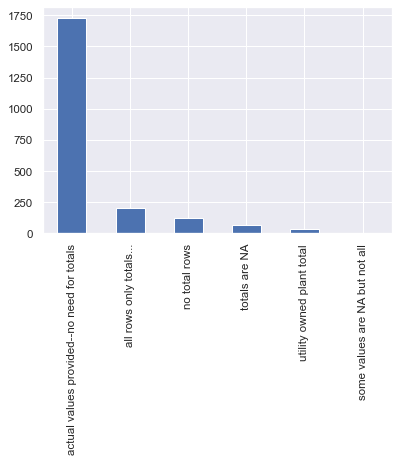

In [2419]:
col_agg_df = col_agg_df.sort_values('plant_id_pudl')
#col_agg_df[col_agg_df['capex_total_flag'].str.contains('some values are NA but not all')]

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
col_agg_df['capex_total_flag'].value_counts().plot(ax=ax, kind='bar')

In [2430]:
col_agg_df[col_agg_df['capex_total_flag'].str.contains('all rows only')].sort_values(['plant_id_pudl', 'report_year']).plant_id_pudl.unique()
#col_agg_df[col_agg_df['avg_num_employees_flag']=='unit total']
#col_agg_df[col_agg_df['plant_id_pudl']==249]

array([  121,   249,   287,   473,   490,   497,   542,   623,   661,
        1083,  1251,  2281,  8466,  8467,  8470,  8580, 11538, 11579,
       11580, 11826])

In [2454]:
mini_df(flagged_steam,249,1994,2003,['capex_total'])
#mini_df(flagged_steam,343,2008,2009, ['avg_num_employees'])
dd = flagged_steam[flagged_steam['plant_name_ferc1'].str.contains('greene')]
dd[basic_view]
flagged_steam[(flagged_steam['utility_id_ferc1']==2) & (flagged_steam['report_year'].isin(range(2017,2020)))][basic_view]
#flagged_steam[flagged_steam['plant_id_pudl']==8467]

,report_year,plant_name_ferc1,utility_id_ferc1,plant_type,primary_fuel,capacity_mw,total_type,plant_id_pudl,primary_fuel_flag,record_id,utility_name_ferc1
25943,2017,gorgas,2,steam,coal,1166.70,None,230,primary fuel by mmbtu,f1_steam_2017_12_2_0_1,ALABAMA POWER COMPANY
25944,2017,gadsden,2,steam,gas,138.00,None,206,single fuel by net generation from eia923,f1_steam_2017_12_2_0_2,ALABAMA POWER COMPANY
25945,2017,barry,2,steam,gas,1498.80,None,32,primary fuel by cost,f1_steam_2017_12_2_0_3,ALABAMA POWER COMPANY
25946,2017,e. c. gaston unit 5,2,steam,gas,952.00,None,178,primary fuel by cost,f1_steam_2017_12_2_0_5,ALABAMA POWER COMPANY
25947,2017,joseph m. farley,2,nuclear,nuclear,1776.50,None,296,fuel in technology name,f1_steam_2017_12_2_1_1,ALABAMA POWER COMPANY
25948,2017,greene county ct,2,combustion_turbine,oil,827.42,None,11490,primary fuel by cost,f1_steam_2017_12_2_1_2,ALABAMA POWER COMPANY
25949,2017,greene county-total,2,steam,gas,341.09,plant total,249,single fuel by net generation from eia923,f1_steam_2017_12_2_1_3,ALABAMA POWER COMPANY
25950,2017,respondent's portion,2,steam,gas,0.00,utility owned plant total,8470,primary fuel by cost,f1_steam_2017_12_2_1_4,ALABAMA POWER COMPANY
25951,2017,j h miller - total,2,steam,coal,2822.00,plant total,287,single fuel by net generation from eia923,f1_steam_2017_12_2_2_1,ALABAMA POWER COMPANY
25952,2017,respondent's portion,2,steam,gas,0.00,utility owned plant total,8470,primary fuel by cost,f1_steam_2017_12_2_2_2,ALABAMA POWER COMPANY


In [2308]:
# Running list of fun problems:
# * If the plant total has a different plant type than the reporting utilitys' then it will come up as it's own 
#   row, probably NA :/
# * When to use total row if there are some components available
# * Unit totals - sometimes can under report (like in avg_emp 343) or over report (like in avg_emp 295)
# * 

In [1187]:
def col_aggregator(flag_df, agg_col):
    """
    Remove total rows from aggregation; use when there are nulls present in non-total rows. 
    
    This function looks at a table grouped by year, utility, and plant and determines whether to use any of the
    information from the total rows in an aggregation based on the column agg_col specified as a parameter.
    If there are no total rows, this function simply takes the sum of each group. If there are totals rows, 
    this function first looks to see if there is a utility owned total reported and then looks to see if there is
    a plant total reported.
    
    The different agg flags are:
    
    * plant total: pudl plant totals where the plant is owned by more than one utility.
    * utility owned total: all of the assets owned by a utility
    * utility owned plant total: a utility's owned portion of a pudl plant
    * utility owned plant total steam: all of the utility's steam assets within a given pudl plant
    * utility owned subtotal: the sum of several units within a pudl plant owned by one utility
    * unit total: the sum of a co-owned unit (sub-pudl plant id)
    
    If the aggregation must resort to using a total row, a flag is created and returned alongside the aggregated value.
    These values will later get split apart and set as seperate columns (in the build_col_agg_df function).
    
    Args: 
        df (pandas.DataFrame): A flagged version of the cleaned ferc1_steam table with the column name 'total_type'
            specifying wither it is a utility owned total, unit total, or plant total.
        agg_col (str): The name of the column you'd like to aggregate by.
    
    """
    
    if flag_df.loc[flag_df['total_type'].isna()][agg_col].notna().all() & len(flag_df.loc[flag_df['total_type'].isna()]) > 0: 
        flag = None
        agg_value = flag_df.loc[flag_df['total_type'].isna()][agg_col].sum()
        return [agg_value, flag]
    elif flag_df['total_type'].str.contains('plant total').any() & flag_df.loc[flag_df['total_type']=='plant total'][agg_col].notna().all():
            flag = 'used plant total pertains to more than one utility'
            agg_value = flag_df.loc[flag_df['total_type']=='plant total'][agg_col].unique()[0]
            return [agg_value, flag]
    else:
        if flag_df['total_type'].str.contains('utility owned plant total').any() & flag_df.loc[flag_df['total_type']=='utility owned total'][agg_col].notna().all():
            flag = None  # 'used utility owned plant total'
            agg_value = flag_df.loc[flag_df['total_type']=='utility owned plant total'][agg_col].unique()[0]
            return [agg_value, flag]
        elif flag_df.loc[flag_df['total_type'].str.contains('utility owned plant total steam')].any() & flag_df.loc[flag_df['plant_type']=='steam'][agg_col].notna().all():
            flag = None  # 'used utility owned plant total steam'
            agg_value = flag_df.loc[flag_df['total_type'] == 'utility owned plant total steam'][agg_col].unique()[0]
        elif flag_df.loc[flag_df['total_type'].isna()][agg_col].isna().all():
            flag = None
            agg_value = np.nan
            return [agg_value, flag]
        else:
            flag = 'aggregated with some null values'
            agg_value = flag_df.loc[flag_df['total_type'].isna()][agg_col].sum()
            return [agg_value, flag]

SyntaxError: invalid syntax (<ipython-input-1187-ada1f4fef60e>, line 34)

In [408]:
def build_col_agg_df(flag_df, agg_col):
    """Sort by field level.
    
    This function creates a mini aggregated dataframe based on a column specified in the parameters. 
    It runs the col_aggregator function so that the aggregations exclude total values unless there are
    gaps in the subcomponents--in which case it will first try and use a reported utility total and 
    then a plant total. The col_aggregator function returns both the aggregated value and flag to
    indicate whether it was aggregated based on a value from one of the total rows. This function turns
    the value and the flag (returned as a list within one column) to seperate columns.
    
    These column-based data aggregations can later be merged to form one large data aggregation column.
    
    Args: 
        df (pandas.DataFrame): A DataFrame....
        agg_col (str): The name of the column you'd like to aggregate by.
    Returns:
        pandas.DataFrame: A DataFrame with rows selected based on priority.
    
    """

    plant_util_group = flag_df.groupby(['report_year', 'utility_id_ferc1', 'plant_id_pudl', 'primary_fuel', 'plant_type'])
    col_agg_series = plant_util_group.apply(lambda x: col_aggregator(x, agg_col))
    col_agg_df = pd.DataFrame(col_agg_series).reset_index()
    col_agg_df[[agg_col, f'{agg_col}_flag']] = pd.DataFrame(col_agg_df[0].tolist(), index=col_agg_df.index)
    col_agg_df = col_agg_df.drop(columns=[0])
    
    def combine_flags(ser):
        if ser.isna().all():
            return None
        else:
            return ', '.join([flag for flag in ser.unique() if flag != None])

    #Group by utility and fuel type
    util_fuel_df = (
        col_agg_df
        .groupby(['report_year', 'utility_id_ferc1', 'primary_fuel'])
        .agg({agg_col: 'sum',
              f'{agg_col}_flag': lambda x: combine_flags(x)})
        .reset_index()
    )
    
    return util_fuel_df

In [409]:
def aggregate_all_columns(df, col_list):
    agg_df = pd.DataFrame(columns=['report_year', 'utility_id_ferc1', 'primary_fuel'])
    for col in col_list:
        col_df = build_col_agg_df(df, col)
        agg_df = pd.merge(agg_df, col_df, on=['report_year', 'utility_id_ferc1', 'primary_fuel'], how='outer')
    return agg_df

In [410]:
complete_util_agg = aggregate_all_columns(flagged_steam, value_cols_no_cap+['capacity_mw'])

In [446]:
#complete_util_agg[complete_util_agg['primary_fuel']=='unknown']
complete_util_agg

,report_year,utility_id_ferc1,primary_fuel,net_generation_mwh,net_generation_mwh_flag,avg_num_employees,avg_num_employees_flag,capex_land,capex_land_flag,capex_equipment,...,opex_boiler,opex_boiler_flag,opex_plants,opex_plants_flag,opex_misc_steam,opex_misc_steam_flag,opex_production_total,opex_production_total_flag,capacity_mw,capacity_mw_flag
0,1994,1,coal,9.119496e+06,used utility owned total,462.0,used plant total pertains to more than one uti...,6469962.0,used utility owned total,5.300235e+08,...,6560762.0,used utility owned total,1150468.0,used utility owned total,1036572.0,used utility owned total,1.839901e+08,used utility owned total,1300.0,used utility owned total
1,1994,2,coal,5.028391e+07,None,2031.0,None,11310431.0,None,3.979206e+09,...,52555239.0,None,12821236.0,None,3462156.0,None,1.216481e+09,None,10148.0,None
2,1994,2,gas,3.388883e+06,None,154.0,None,331497.0,None,1.251836e+08,...,2866852.0,None,692054.0,None,458325.0,None,3.882226e+07,None,614.0,None
3,1994,2,nuclear,1.320825e+07,None,894.0,None,1454214.0,None,1.397899e+09,...,18601315.0,None,8937024.0,None,8814524.0,None,1.902891e+08,None,1777.0,None
4,1994,2,unknown,4.703416e+05,None,0.0,None,183261.0,None,9.493402e+07,...,1361835.0,None,252704.0,None,207816.0,None,6.494924e+06,None,115.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7738,2019,519,gas,6.447320e+05,None,16.0,None,2121938.0,None,1.539476e+08,...,0.0,None,1852337.0,None,0.0,None,1.736698e+07,None,188.0,None
7739,2019,529,coal,0.000000e+00,None,0.0,None,34510845.0,aggregated with some null values,1.483039e+09,...,0.0,None,0.0,None,0.0,None,0.000000e+00,None,0.0,aggregated with some null values
7740,2019,531,coal,1.611511e+07,None,670.0,None,10225928.0,None,3.096751e+09,...,76179710.0,None,18827008.0,None,2372785.0,None,4.756402e+08,None,3671.0,None
7741,2019,531,gas,2.469732e+06,None,42.0,None,2852666.0,None,1.135614e+09,...,658775.0,None,10723561.0,None,0.0,None,8.997181e+07,None,1224.0,None
